In [1]:
!nvidia-smi

Fri Jun 10 08:51:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# new tensorflow for RandomBrighness layer
#!pip install -U tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/datasets/nomo_nailbiting/faces_image_dataset.zip" -d "/content"

In [6]:
!ls "/content/image_dataset"

biting	no_biting


In [24]:
from tensorflow.keras.utils import image_dataset_from_directory

path_to_data = "/content/faces_image_dataset"

class_names = ['no_biting', 'biting']

train_ds = image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    label_mode='binary',
    class_names=['no_biting', 'biting'],
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

val_ds = image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    label_mode='binary',
    class_names=['no_biting', 'biting'],
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 684 files belonging to 2 classes.
Using 548 files for training.
Found 684 files belonging to 2 classes.
Using 136 files for validation.


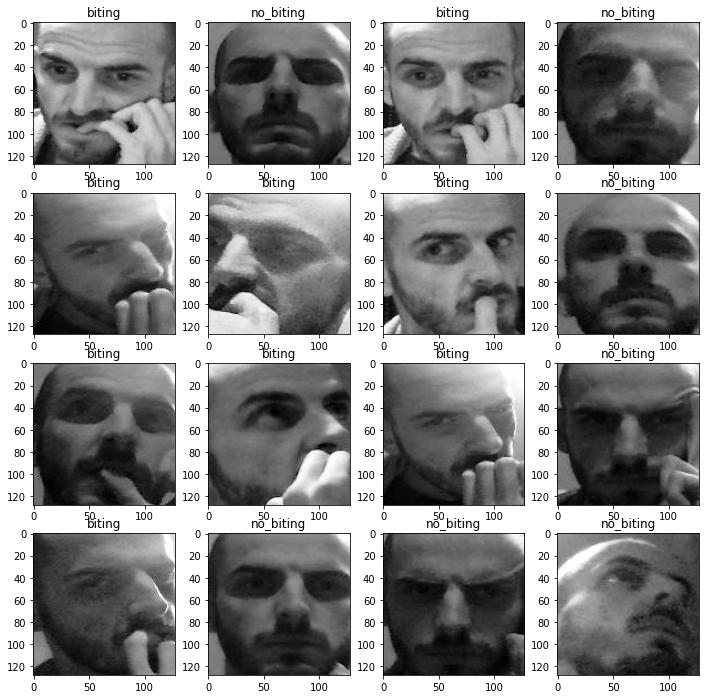

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# explore some data

fig, axes = plt.subplots(4, 4, figsize = (12, 12))

for x_batch, y_batch in train_ds.take(1).as_numpy_iterator():
    for img, label, ax in zip(x_batch, y_batch, axes.flat):
        ax.imshow(np.squeeze(img), cmap = 'Greys_r')
        ax.set_title(f'{class_names[int(label)]}')


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.layers import RandomContrast, RandomZoom, RandomRotation, RandomTranslation, RandomFlip #, RandomBrightness


In [27]:
# order of data augmentation? brightness & contrast

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def model_init():

    model = Sequential([
        Rescaling(1/255, input_shape = (256, 256, 1)),
        #RandomBrightness(factor = 0.2, value_range = (0, 1)),
        RandomContrast(0.2),
        RandomZoom(0.2),
        RandomRotation(0.2),
        RandomTranslation(0.2, 0.2),
        RandomFlip('horizontal'),
        Conv2D(16, (10, 10), activation = 'relu'),
        MaxPooling2D(2),
        Conv2D(32, (8, 8), activation = 'relu'),
        MaxPooling2D(2),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D(2),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.4),
        Dense(1, activation ='sigmoid'),
    ])

    model.compile(loss = 'binary_crossentropy',
                optimizer = Adam(0.000001),
                metrics = ['accuracy',Precision(), Recall()])

    return model

In [28]:
model = model_init()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 random_contrast_6 (RandomCo  (None, 256, 256, 1)      0         
 ntrast)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 1)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 256, 256, 1)      0         
 tation)                                                         
                                                                 
 random_translation_2 (Rando  (None, 256, 256, 1)      0         
 mTranslation)                                                   
                                                      

In [33]:
def face_model_init():

    model = Sequential([
        Rescaling(1/255, input_shape = (128, 128, 1)),
        #RandomBrightness(factor = 0.2, value_range = (0, 1)),
        RandomContrast(0.1),
        #RandomZoom(0.2),
        RandomRotation(0.1),
        #RandomTranslation(0.2, 0.2),
        RandomFlip('horizontal'),
        Conv2D(16, (10, 10), activation = 'relu'),
        MaxPooling2D(2),
        Conv2D(32, (8, 8), activation = 'relu'),
        MaxPooling2D(2),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D(2),
        #Conv2D(64, (5, 5), activation = 'relu'),
        #MaxPooling2D(2),
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.4),
        Dense(1, activation ='sigmoid'),
    ])

    model.compile(loss = 'binary_crossentropy',
                optimizer = Adam(0.00001),
                metrics = ['accuracy',Precision(), Recall()])

    return model

In [34]:
model = face_model_init()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 random_contrast_9 (RandomCo  (None, 128, 128, 1)      0         
 ntrast)                                                         
                                                                 
 random_rotation_9 (RandomRo  (None, 128, 128, 1)      0         
 tation)                                                         
                                                                 
 random_flip_9 (RandomFlip)  (None, 128, 128, 1)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 119, 119, 16)      1616      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 59, 59, 16)      

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 30, restore_best_weights = True)

face_model = face_model_init()

history = face_model.fit(train_ds,
         validation_data = val_ds,
         epochs = 500,
         callbacks = [es]).history

Epoch 1/500
18/18 [==============================] - 2s 44ms/step - loss: 0.6910 - accuracy: 0.4854 - precision_12: 0.4927 - recall_12: 0.8582 - val_loss: 0.6906 - val_accuracy: 0.4926 - val_precision_12: 0.4926 - val_recall_12: 1.0000
Epoch 2/500
18/18 [==============================] - 1s 24ms/step - loss: 0.6890 - accuracy: 0.5000 - precision_12: 0.5009 - recall_12: 0.9891 - val_loss: 0.6888 - val_accuracy: 0.4926 - val_precision_12: 0.4926 - val_recall_12: 1.0000
Epoch 3/500
18/18 [==============================] - 1s 22ms/step - loss: 0.6818 - accuracy: 0.5018 - precision_12: 0.5018 - recall_12: 0.9891 - val_loss: 0.6852 - val_accuracy: 0.4926 - val_precision_12: 0.4926 - val_recall_12: 1.0000
Epoch 4/500
18/18 [==============================] - 0s 23ms/step - loss: 0.6799 - accuracy: 0.5182 - precision_12: 0.5103 - recall_12: 0.9891 - val_loss: 0.6816 - val_accuracy: 0.4926 - val_precision_12: 0.4926 - val_recall_12: 1.0000
Epoch 5/500
18/18 [==============================] - 0s 

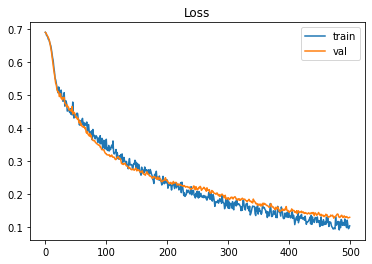

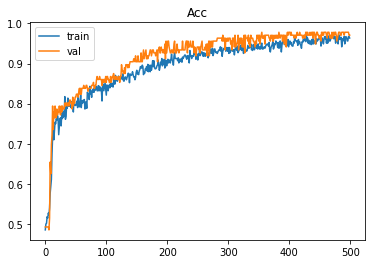

In [41]:
# faces model
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.title('Loss')
plt.show();
plt.plot(history['accuracy'], label = 'train')
plt.plot(history['val_accuracy'], label = 'val')
plt.legend()
plt.title('Acc')
plt.show();


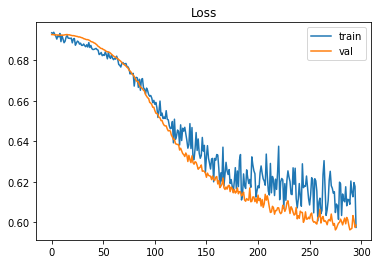

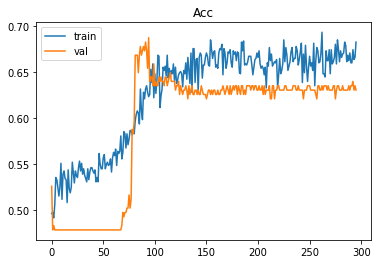

In [34]:
# whole image model
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.title('Loss')
plt.show();
plt.plot(history['accuracy'], label = 'train')
plt.plot(history['val_accuracy'], label = 'val')
plt.legend()
plt.title('Acc')
plt.show();


In [18]:
# best 97.06% accuracy

In [43]:
face_model.save('face_model')
!zip -r face_model.zip face_model

INFO:tensorflow:Assets written to: face_model/assets
  adding: face_model/ (stored 0%)
  adding: face_model/saved_model.pb (deflated 89%)
  adding: face_model/keras_metadata.pb (deflated 91%)
  adding: face_model/assets/ (stored 0%)
  adding: face_model/variables/ (stored 0%)
  adding: face_model/variables/variables.index (deflated 67%)
  adding: face_model/variables/variables.data-00000-of-00001 (deflated 12%)


In [16]:
!ls

drive  image_dataset  __MACOSX	sample_data
